In [ ]:
# not strictly necessary, but imported anyway for the IDE haha
import torch
from torchvision import datasets, transforms 

No of images in training set: 835
No of images in validation set: 104
No of images in test set: 105
No of images in feeder set: 15079
Labels: ['blueTit', 'chaffinch', 'coalTit', 'goldfinch', 'greatTit', 'robin', 'starling']
Labels (feeder): ['blueTit', 'chaffinchF', 'chaffinchM', 'coalTit', 'goldfinch', 'greatTit', 'robin', 'starling']


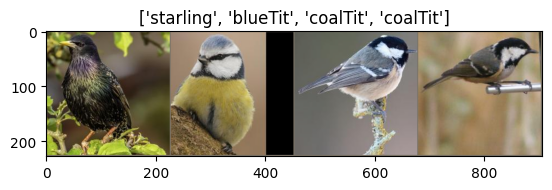

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
%run setup.ipynb # should take like 20 seconds i think

# Training with augmentation

Now we've trained our model and assessed its performance on the feeder data... it's not the worst, but let's see if we can't make it a bit stronger by adding augmentations.

In [ ]:
# Defining the transforms including augmentations (and also the basic ToTensor and normalisation)
preprocess_with_augmentation1 = transforms.Compose([
    transforms.ColorJitter(brightness=0.1),
    transforms.GaussianBlur(kernel_size=(5,5), sigma=(7, 9)),
    transforms.RandomRotation(degrees=10),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomResizedCrop(size=224,scale=(0.3,1)), # lowerbound the sacle at 30 % of og img to not get too small portions
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Datasets and loaders with augmentations added 
# FIXME should we in actuality be ADDING the augmented and the non-augmented dataset together?
dataset_train_aug1 = datasets.ImageFolder(PATH_TRAIN, preprocess_with_augmentation1)
dataloader_train_aug1 = torch.utils.data.DataLoader(dataset_train_aug1, batch_size=4, shuffle=True, num_workers=4)
# NOTE: no augs on the validation, righT?
#dataset_val_aug1 = datasets.ImageFolder(PATH_VAL, preprocess_with_augmentation1)
#dataloader_val_aug1 = torch.utils.data.DataLoader(dataset_val_aug1, batch_size=4, shuffle=True, num_workers=4)

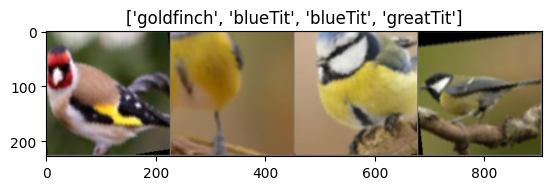

In [14]:
# looking at the augmentations..
inputs, classes = next(iter(dataloader_train_aug1))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_labels[x] for x in classes])

Proceeding to the training...

In [ ]:
trained_model_aug1, model_aug1_info = train_model(model=resnet50, optimizer=optimizer, num_epoch=5, train=dataloader_train_aug1)
print("\n ----\n")
print(model_aug1_info)

Epoch 1/5
----------
Train Loss: 1.8147 Acc: 0.3425
Val Loss: 1.7656 Acc: 0.3462
Epoch time 0m 56s
----------

Epoch 2/5
----------
Train Loss: 1.5236 Acc: 0.5772
Val Loss: 1.6194 Acc: 0.4135
Epoch time 2m 12s
----------

Epoch 3/5
----------
Train Loss: 1.3774 Acc: 0.6012
Val Loss: 1.5542 Acc: 0.5096
Epoch time 3m 22s
----------

Epoch 4/5
----------
Train Loss: 1.2318 Acc: 0.6659
Val Loss: 1.4738 Acc: 0.5192
Epoch time 4m 32s
----------

Epoch 5/5
----------
Train Loss: 1.1678 Acc: 0.6826
Val Loss: 1.3496 Acc: 0.6250
Epoch time 5m 43s
----------

Training complete in 5m 43s
Validation accuracies:
[0.34615384615384615, 0.41346153846153844, 0.5096153846153846, 0.5192307692307693, 0.625]


TypeError: can only concatenate str (not "dict") to str

In [16]:
print("\n ----\n")
print(model_aug1_info)


 ----

{'train_loss': [1.8147176618347625, 1.5235897937934555, 1.3774094678684623, 1.2318039675672612, 1.167776976802392], 'val_loss': [1.7655774217385511, 1.6193799376487732, 1.554198641043443, 1.4737999209990869, 1.3496281252457545], 'train_acc': [0.34251497005988024, 0.577245508982036, 0.6011976047904192, 0.665868263473054, 0.6826347305389222], 'val_acc': [0.34615384615384615, 0.41346153846153844, 0.5096153846153846, 0.5192307692307693, 0.625]}
